In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import sys
from anndata import AnnData

# sys.path.append("/home/icb/giovanni.palla/code/spatial-alignment/data")
# from data.simulated.generate_twod_data import generate_twod_data_partial_overlap

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

adata = adata[adata.obs.synth_batch == "2"].copy()
# arr_obs = np.repeat(np.arange(adata.shape[0] / 2)[:, None], adata.shape[1], 1)
# arr_obs = np.vstack([arr_obs.copy(), arr_obs.copy()])

# arr_var = np.repeat(np.arange(adata.shape[1] / 2)[None, :], adata.shape[0], 0)
# arr_var = np.hstack([arr_var.copy(), arr_var.copy()])

# adata.X = adata.X.copy() + arr_obs + arr_var
adata.X = np.random.normal(size=adata.X.shape) + adata.X.copy()
p = 0.8
idx_subsample = np.random.choice([True, False], size=(adata.shape[0]), p=[p, 1 - p])
adata = adata[idx_subsample].copy()
# sc.pp.pca(adata)
# adata = adata[~((adata.obs.idx == 100) & (adata.obs.batch == 0))].copy()
# sc.pp.subsample(adata, fraction=0.999)


adata

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 2566 × 500
    obs: 'batch', 'idx', 'synth_batch'
    obsm: 'spatial'

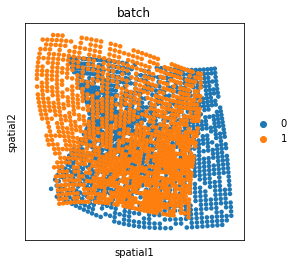

In [4]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from gpsa.models.vgpsa import VariationalGPSA
from gpsa import matern12_kernel, rbf_kernel
from gpsa.plotting import callback_twod

device = "cuda" if torch.cuda.is_available() else "cpu"

X = adata.obsm["spatial"].copy()
Y = adata.X.copy()
view_idx = [np.where(adata.obs.batch.values == ii)[0] for ii in range(2)]
n_samples_list = [len(x) for x in view_idx]

x = torch.from_numpy(X).float().clone()
y = torch.from_numpy(Y).float().clone()

data_dict = {
    "expression": {
        "spatial_coords": x,
        "outputs": y,
        "n_samples_list": n_samples_list,
    }
}

In [6]:
N_SPATIAL_DIMS = 2
N_VIEWS = 2
M_G = 50
M_X_PER_VIEW = 50
N_OUTPUTS = 5
FIXED_VIEW_IDX = 0
N_LATENT_GPS = {"expression": None}

N_EPOCHS = 10
PRINT_EVERY = 1

model = VariationalGPSA(
    data_dict,
    n_spatial_dims=N_SPATIAL_DIMS,
    m_X_per_view=M_X_PER_VIEW,
    m_G=M_G,
    data_init=True,
    minmax_init=False,
    grid_init=False,
    n_latent_gps=N_LATENT_GPS,
    mean_function="identity_fixed",
    kernel_func_warp=rbf_kernel,
    kernel_func_data=rbf_kernel,
    fixed_view_idx=FIXED_VIEW_IDX,
).to(device)

view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
def train(model, loss_fn, optimizer):
    model.train()

    # Forward pass
    G_means, G_samples, F_latent_samples, F_samples = model.forward(
        {"expression": x}, view_idx=view_idx, Ns=Ns, S=5
    )

    # Compute loss
    loss = loss_fn(data_dict, F_samples)

    # Compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), G_means


for t in range(N_EPOCHS):
    loss, G_means = train(model, model.loss_fn, optimizer)
print("Done!")

Done!


In [8]:
G_means["expression"].detach().numpy()

array([[-1.4386377 , -1.7534232 ],
       [-1.3802589 , -1.752886  ],
       [-1.3217183 , -1.7521362 ],
       ...,
       [ 0.6498013 ,  1.5763036 ],
       [ 0.73006994,  1.5821583 ],
       [ 1.0877877 ,  1.579783  ]], dtype=float32)

In [9]:
adata.obsm["spatial_aligned"] = G_means["expression"].detach().numpy()

In [10]:
adata.obsm["spatial_aligned"].shape

(2566, 2)

In [11]:
adata.shape

(2566, 500)

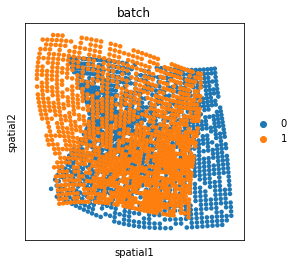

In [12]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

In [13]:
adata_gpsa = adata.copy()

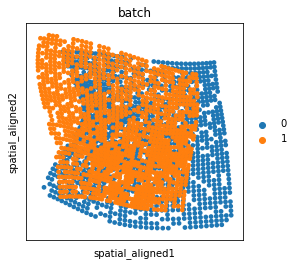

In [14]:
sc.pl.spatial(adata, basis="spatial_aligned", spot_size=0.1, color="batch")

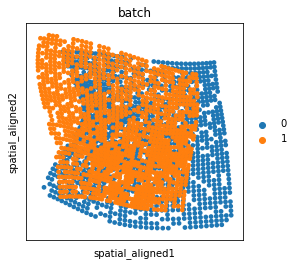

In [15]:
sc.pl.spatial(adata_gpsa, basis="spatial_aligned", spot_size=0.1, color="batch")

In [16]:
adata.shape

(2566, 500)

In [17]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
inter, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
mean_squared_error(
    ad1.obsm["spatial_aligned"][comm1][:, 1], ad2.obsm["spatial_aligned"][comm2][:, 1]
)

0.0816599